In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Importar Dataframe que contiene el trabajo semanal en la linea de volúmenes
df_vols_trabajo_semanal = pd.read_excel('./dataframes/df_vols_trabajo_semanal.xlsx')

In [3]:
df_lstm = df_vols_trabajo_semanal.rename(columns={"semana_primer_dia": "ds", "tiempo_trabajo_horas": "y"})
df_lstm = df_lstm.drop(['semana', 'cantidad_fabricada', 'tiempo_trabajo', 'Unnamed: 0'], axis=1)

In [4]:
ultima_fecha = df_lstm['ds'].max()
fechas_futuras = [ultima_fecha + pd.DateOffset(weeks=i+1) for i in range(16)]

In [5]:
df_lstm['week'] = df_lstm['ds'].dt.isocalendar().week
df_lstm['year'] = df_lstm['ds'].dt.isocalendar().year
df_lstm['month'] = df_lstm['ds'].dt.month

def is_holiday(y):
    
    # Si y no es None, aplicar el criterio original
    if y < 10:
        return 1
    else:
        return 0

def is_holiday_future(ds):
    week = ds.isocalendar().week
    month = ds.month
    
    # Verificar si la semana está en las semanas 32 o 33 de agosto
    if (week == 32 or week == 33) and month == 8:
        return 1
    else:
        return 0

df_lstm['holiday'] = df_lstm.apply(lambda row: is_holiday(row['y']), axis=1)

df_lstm_copia = df_lstm.copy()

In [6]:
df_lstm = pd.get_dummies(df_lstm, columns=['month', 'holiday'], drop_first=True)

In [7]:
df_lstm = df_lstm.drop('ds', axis = 1)
df_lstm = np.array(df_lstm).astype(np.float32)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(df_lstm)
scaled_data = pd.DataFrame(scaled_data)

In [9]:
#Mejor
sequence_length = 30 
#sequence_length = 52 Peor
#sequence_length = 20

X, y = [], []
for i in range(sequence_length, len(df_lstm)):

    data_append_X = scaled_data.iloc[i-sequence_length:i]
    
    X.append(data_append_X)
    
    y.append(scaled_data.iloc[i][0])

X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)

In [10]:
#DF Futuro
df_futuro = pd.DataFrame({'ds': fechas_futuras, 'y': np.nan})
df_futuro['week'] = df_futuro['ds'].dt.isocalendar().week
df_futuro['year'] = df_futuro['ds'].dt.isocalendar().year
df_futuro['month'] = df_futuro['ds'].dt.month

df_futuro['holiday'] = df_futuro.apply(lambda row: is_holiday(row['y']), axis=1)
df_futuro['holiday'] = df_futuro.apply(lambda row: is_holiday_future(row['ds']), axis=1)

df_futuro = pd.get_dummies(df_futuro, columns=['month', 'holiday'], drop_first=False)

In [11]:
import pandas as pd

# Lista con el orden deseado de las columnas
orden_deseado = [
    'ds', 'y', 'week', 'year', 
    'month_2', 'month_3', 'month_4', 'month_5', 
    'month_6', 'month_7', 'month_8', 'month_9', 
    'month_10', 'month_11', 'month_12', 
    'holiday_1'
]

# Asegúrate de que todas las columnas necesarias estén presentes
for col in orden_deseado:
    if col not in df_futuro.columns:
        df_futuro[col] = False

# Reordenar el DataFrame según el orden deseado
df_futuro = df_futuro[orden_deseado]

In [12]:
df_futuro = df_futuro.drop('ds', axis = 1)
df_futuro = np.array(df_futuro).astype(np.float32)

scaled_data_future = scaler.transform(df_futuro)
scaled_data_future = pd.DataFrame(scaled_data_future)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, shuffle=False, random_state=101)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Definir el modelo
model = Sequential()

# Primera capa LSTM con 250 unidades y Dropout de 0.2
model.add(LSTM(units=350, return_sequences=True, input_shape=(sequence_length, 15), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))  # Dropout reducido para capturar más detalles

# Segunda capa LSTM con 150 unidades y Dropout de 0.15
model.add(LSTM(units=150, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.15))  # Dropout reducido

# Tercera capa LSTM con 100 unidades y Dropout de 0.1
model.add(LSTM(units=100))
model.add(Dropout(0.1))

# Capa densa (fully connected) de salida
model.add(Dense(units=1))  # Sin activación para regresión

# Compilar el modelo con tasa de aprendizaje más baja
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='mse')
#Probado learning Rate 0.0001 peor. 0.0003 optimo.

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Ver la arquitectura del modelo
model.summary()


Epoch 1/70
4/4 [==============================] - 6s 465ms/step - loss: 0.7031 - val_loss: 0.5077
Epoch 2/70
4/4 [==============================] - 1s 195ms/step - loss: 0.5252 - val_loss: 0.5339
Epoch 3/70
4/4 [==============================] - 1s 189ms/step - loss: 0.4840 - val_loss: 0.4715
Epoch 4/70
4/4 [==============================] - 1s 190ms/step - loss: 0.4783 - val_loss: 0.4575
Epoch 5/70
4/4 [==============================] - 1s 191ms/step - loss: 0.4534 - val_loss: 0.4441
Epoch 6/70
4/4 [==============================] - 1s 192ms/step - loss: 0.4366 - val_loss: 0.4340
Epoch 7/70
4/4 [==============================] - 1s 192ms/step - loss: 0.4199 - val_loss: 0.4115
Epoch 8/70
4/4 [==============================] - 1s 208ms/step - loss: 0.4054 - val_loss: 0.3984
Epoch 9/70
4/4 [==============================] - 1s 183ms/step - loss: 0.3924 - val_loss: 0.3848
Epoch 10/70
4/4 [==============================] - 1s 175ms/step - loss: 0.3772 - val_loss: 0.3724
Epoch 11/70
4/4 [==

In [15]:
# Extraer los datos de pérdida de entrenamiento y validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']

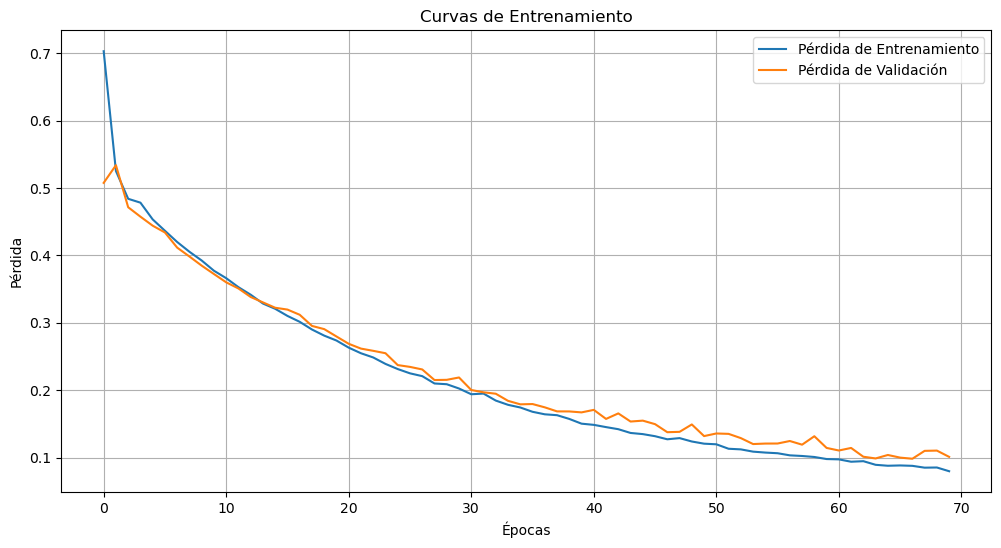

In [16]:
# Graficar las curvas de pérdida
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Pérdida de Entrenamiento')
plt.plot(val_loss, label='Pérdida de Validación')
plt.title('Curvas de Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Hacer predicciones
predicted = model.predict(X_test)

1/1 [==============================] - 1s 873ms/step


In [18]:
predicted_scaled = np.zeros((predicted.shape[0], 15))
predicted_scaled[:, 0] = predicted.squeeze()
predicted_descaled = scaler.inverse_transform(predicted_scaled)[:, 0]

In [19]:
y_test_scaled = np.zeros((y_test.shape[0], 15))
y_test_scaled[:, 0] = y_test.squeeze()
y_test_descaled  = scaler.inverse_transform(y_test_scaled)[:, 0]

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test_descaled, predicted_descaled))
mae = mean_absolute_error(y_test_descaled, predicted_descaled)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


RMSE: 6.051441863144112
MAE: 5.19257661647142


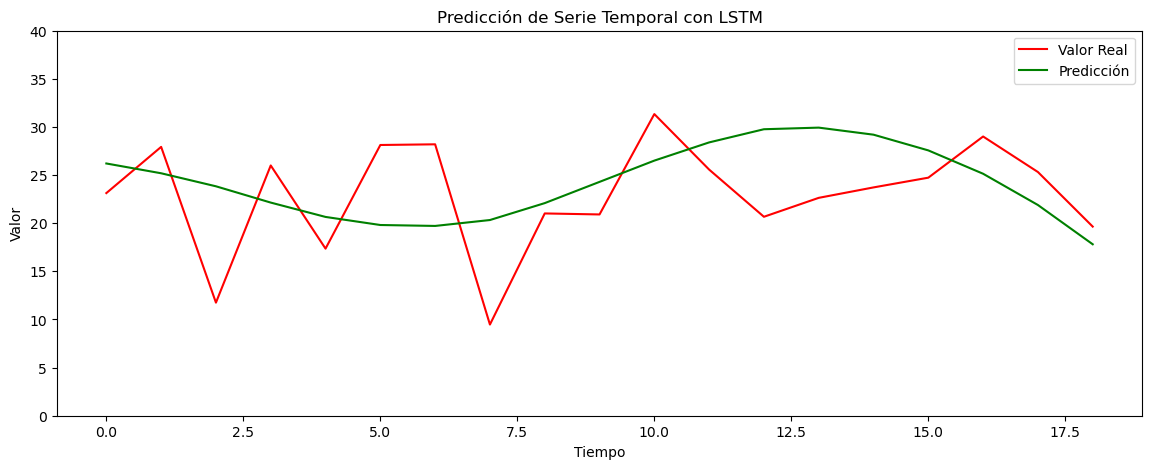

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(y_test_descaled, color='red', label='Valor Real')
plt.plot(predicted_descaled, color='green', label='Predicción')
plt.title('Predicción de Serie Temporal con LSTM')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.ylim(0,40)
plt.legend()
plt.show()

Desvación de 0: -1.2598097978006473


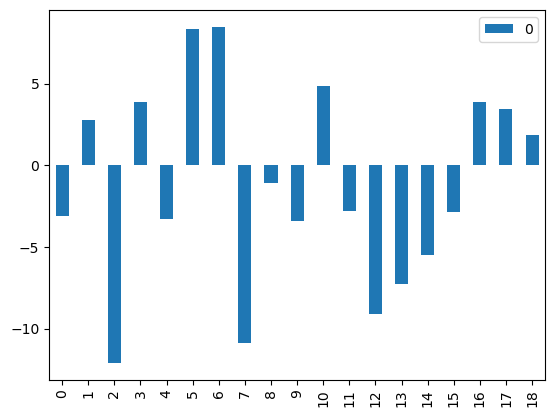

In [22]:
error = pd.DataFrame(y_test_descaled-predicted_descaled)
error.plot(kind = 'bar')
desviación_error = error.mean()
desviación_error = float(desviación_error.iloc[0])
print('Desvación de 0: ' + str(desviación_error))

In [23]:
#FALTA UNA SEMANA!!!!

scaled_data_future

data_future = scaled_data_future.values

In [24]:
import numpy as np

# Definir la cantidad de predicciones futuras que deseas (por ejemplo, 16 semanas)
n_predicciones = 16

# Obtener la última secuencia disponible de X_test o tu dataset de entrenamiento
ultima_secuencia = X_test[-1]  # Suponiendo que 'X_test' contiene secuencias de tamaño (30, n_features)

# Crear una lista para almacenar las predicciones futuras
predicciones_futuras = []

# Iterar para predecir futuras semanas
for i in range(n_predicciones):
    # Hacer la predicción para la última secuencia
    prediccion = model.predict(ultima_secuencia[np.newaxis, :, :])  # np.newaxis para agregar dimensión extra
    
    # Guardar la predicción
    predicciones_futuras.append(prediccion[0][0])
    
    # Crear la nueva secuencia
    nueva_fila = np.copy(ultima_secuencia[-1])  # Copia la última fila de la secuencia actual
    nueva_fila[0] = prediccion  # Reemplaza el valor de 'y' en la nueva fila

    
    # Si 'scaled_data_future' tiene características adicionales que no están en 'ultima_secuencia'
    if i < len(data_future):
        nueva_fila[1:] = data_future[i, 1:]  # Reemplaza las características one-hot encoding con los datos futuros
    else:
        nueva_fila[1:] = ultima_secuencia[-1, 1:]  # Mantener las características actuales si no hay más datos futuros

    # Eliminar la semana más antigua y agregar la nueva predicción
    nueva_secuencia = np.append(ultima_secuencia[1:], [nueva_fila], axis=0)  # Reemplazar la secuencia
    ultima_secuencia = nueva_secuencia  # Actualizar la secuencia

# Si los datos están escalados, puedes desescalar las predicciones:
# Suponiendo que 'predicciones_futuras' es un array unidimensional con las predicciones
predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)  # Asegúrate de que tenga la forma (n_samples, 1

predicciones_futuras_escaladas = np.zeros((predicciones_futuras.shape[0], 15))
predicciones_futuras_escaladas[:, 0] = predicciones_futuras.squeeze()
predicciones_futuras_desescaladas  = scaler.inverse_transform(predicciones_futuras_escaladas)[:, 0]

1/1 [==============================] - ETA: 0s

C:\Users\Usuario\AppData\Local\Temp\ipykernel_10384\360634323.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nueva_fila[0] = prediccion  # Reemplaza el valor de 'y' en la nueva fila


1/1 [==============================] - 0s 26ms/step


<Axes: >

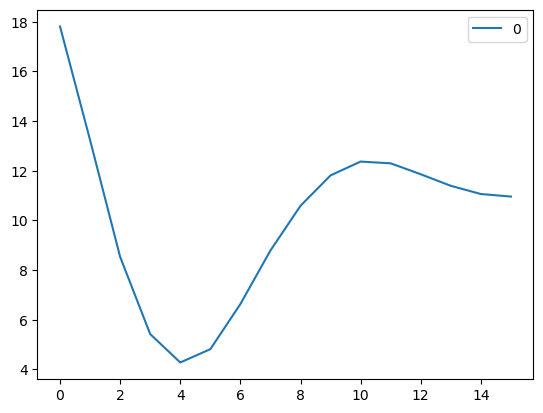

In [25]:
pd.DataFrame(predicciones_futuras_desescaladas).plot()

In [26]:
y_pred_lstm_datos = {
'ds': fechas_futuras,
'yhat': predicciones_futuras_desescaladas
}

y_pred_lstm = pd.DataFrame(y_pred_lstm_datos)

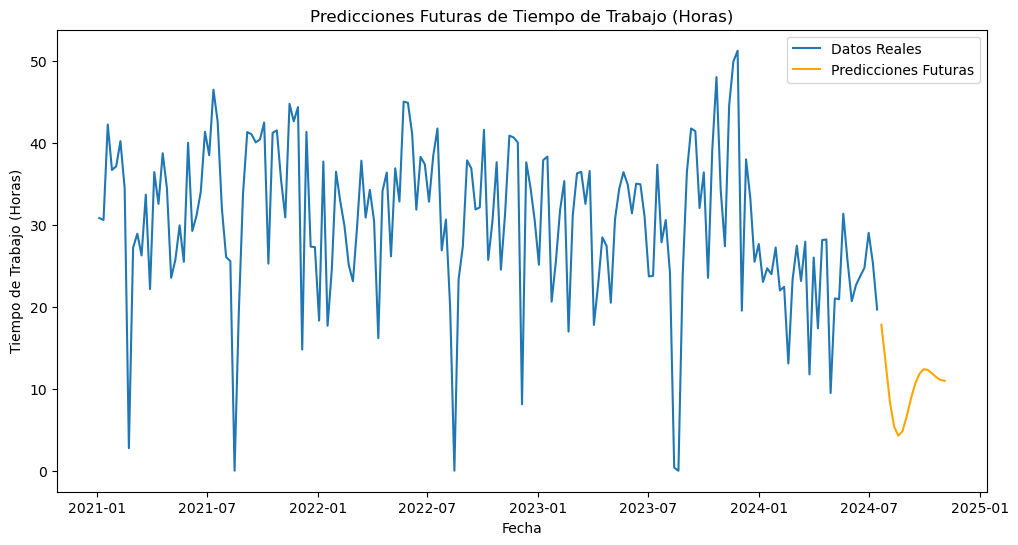

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(df_lstm_copia['ds'], df_lstm_copia['y'], label='Datos Reales')
plt.plot(y_pred_lstm['ds'], y_pred_lstm['yhat'], label='Predicciones Futuras', color='orange')
plt.title('Predicciones Futuras de Tiempo de Trabajo (Horas)')
plt.xlabel('Fecha')
plt.ylabel('Tiempo de Trabajo (Horas)')
plt.legend()
plt.show()


In [28]:
y_pred_lstm.to_excel('./predictions/y_pred_lstm.xlsx')